# Phase 1: Exploratory Data Analysis (EDA)
## CHB-MIT Scalp EEG Database - Epilepsy Seizure Detection

This notebook performs comprehensive exploratory data analysis on the CHB-MIT Pediatric Seizure EEG dataset.

**Dataset:** CHB-MIT Scalp EEG Database  
**Source:** Kaggle - Seizure Epilepsy CHB MIT EEG Dataset Pediatric

## 1. Setup and Import Libraries

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# EEG specific libraries
import mne
import pyedflib

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Download Dataset from Kaggle

**Note:** You need to have Kaggle API credentials configured.  
Place your `kaggle.json` in `~/.kaggle/` directory.

In [2]:
# Setup paths
BASE_DIR = Path(r"c:\Users\Pranaav_Prasad\OneDrive\Desktop\Projects\Epilepsy-Detection")
RAW_DATA_DIR = BASE_DIR / "data" / "raw"
PROCESSED_DATA_DIR = BASE_DIR / "data" / "processed"

# Create directories if they don't exist
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base Directory: {BASE_DIR}")
print(f"Raw Data Directory: {RAW_DATA_DIR}")
print(f"Processed Data Directory: {PROCESSED_DATA_DIR}")

Base Directory: c:\Users\Pranaav_Prasad\OneDrive\Desktop\Projects\Epilepsy-Detection
Raw Data Directory: c:\Users\Pranaav_Prasad\OneDrive\Desktop\Projects\Epilepsy-Detection\data\raw
Processed Data Directory: c:\Users\Pranaav_Prasad\OneDrive\Desktop\Projects\Epilepsy-Detection\data\processed


In [17]:
# Download dataset using Kaggle API with progress
import subprocess
import re
from tqdm.notebook import tqdm

dataset_name = "abhishekinnvonix/seizure-epilepcy-chb-mit-eeg-dataset-pediatric"

# Check if dataset already exists
if not (RAW_DATA_DIR / "chb-mit-scalp-eeg-database-1.0.0").exists():
    print("Downloading dataset from Kaggle (using kaggle CLI)...")
    print("This may take a while (Dataset size: ~40GB)\n")

    cmd = [
        "kaggle", "datasets", "download",
        "-d", dataset_name,
        "-p", str(RAW_DATA_DIR),
        "--unzip"
    ]

    # Ensure kaggle CLI available
    try:
        proc = subprocess.Popen(
            cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, bufsize=1
        )
    except FileNotFoundError:
        raise RuntimeError(
            "kaggle CLI not found. Install it (`pip install kaggle`) and ensure ~/.kaggle/kaggle.json is configured."
        )

    pbar = tqdm(total=100, desc="Download", unit="%")
    last_pct = 0

    for line in proc.stdout:
        line = line.strip()
        # Print raw output (keeps useful messages)
        print(line)
        # Parse percentage like " 42%" or "42%"
        m = re.search(r"(\d{1,3})\s*%|\| *(\d{1,3})%", line)
        if m:
            pct = int(m.group(1) or m.group(2))
            # update tqdm by the delta
            delta = max(0, pct - last_pct)
            if delta:
                pbar.update(delta)
                last_pct = pct

    proc.wait()
    pbar.close()

    if proc.returncode == 0:
        print("\n✓ Dataset downloaded and unzipped successfully")
    else:
        raise RuntimeError(f"Kaggle CLI failed with exit code {proc.returncode}")
else:
    print("✓ Dataset already exists in the raw data directory")

✓ Dataset already exists in the raw data directory


## 3. Dataset Structure Exploration

In [18]:
# Locate the dataset directory
dataset_path = RAW_DATA_DIR / "chb-mit-scalp-eeg-database-1.0.0"

if not dataset_path.exists():
    # Try alternative paths
    possible_paths = list(RAW_DATA_DIR.glob("*"))
    print("Available directories in raw data:")
    for p in possible_paths:
        print(f"  - {p.name}")
    
    # Use the first directory if available
    if possible_paths:
        dataset_path = possible_paths[0]
        print(f"\nUsing: {dataset_path}")
else:
    print(f"✓ Dataset found at: {dataset_path}")

# List all subject folders
subject_folders = sorted([f for f in dataset_path.iterdir() if f.is_dir() and f.name.startswith('chb')])

print(f"\nTotal number of subjects: {len(subject_folders)}")
print("\nSubject IDs:")
for folder in subject_folders:
    print(f"  - {folder.name}")

✓ Dataset found at: c:\Users\Pranaav_Prasad\OneDrive\Desktop\Projects\Epilepsy-Detection\data\raw\chb-mit-scalp-eeg-database-1.0.0

Total number of subjects: 24

Subject IDs:
  - chb01
  - chb02
  - chb03
  - chb04
  - chb05
  - chb06
  - chb07
  - chb08
  - chb09
  - chb10
  - chb11
  - chb12
  - chb13
  - chb14
  - chb15
  - chb16
  - chb17
  - chb18
  - chb19
  - chb20
  - chb21
  - chb22
  - chb23
  - chb24


## 4. Analyze Subject Data Distribution

In [19]:
# Collect metadata for each subject
subject_data = []

print("Analyzing subject data...\n")

for subject_folder in tqdm(subject_folders, desc="Processing subjects"):
    subject_id = subject_folder.name
    
    # Count EDF files
    edf_files = list(subject_folder.glob("*.edf"))
    num_files = len(edf_files)
    
    # Get summary file if exists
    summary_file = subject_folder / f"{subject_id}-summary.txt"
    
    num_seizures = 0
    seizure_files = []
    
    if summary_file.exists():
        with open(summary_file, 'r') as f:
            content = f.read()
            # Count seizure occurrences
            num_seizures = content.count('Seizure Start Time')
            
            # Extract seizure file names
            for line in content.split('\n'):
                if 'File Name:' in line and 'seizure' in content[max(0, content.index(line)-200):content.index(line)+200].lower():
                    seizure_files.append(line.split(':')[1].strip())
    
    # Calculate total size
    total_size_mb = sum(f.stat().st_size for f in edf_files) / (1024 * 1024)
    
    subject_data.append({
        'Subject_ID': subject_id,
        'Num_Files': num_files,
        'Num_Seizures': num_seizures,
        'Total_Size_MB': round(total_size_mb, 2),
        'Has_Seizures': num_seizures > 0
    })

# Create DataFrame
df_subjects = pd.DataFrame(subject_data)

print("\n✓ Subject analysis complete")
print(f"\nDataset Overview:")
print(f"  Total Subjects: {len(df_subjects)}")
print(f"  Subjects with Seizures: {df_subjects['Has_Seizures'].sum()}")
print(f"  Total EDF Files: {df_subjects['Num_Files'].sum()}")
print(f"  Total Seizure Events: {df_subjects['Num_Seizures'].sum()}")
print(f"  Total Dataset Size: {df_subjects['Total_Size_MB'].sum():.2f} MB ({df_subjects['Total_Size_MB'].sum()/1024:.2f} GB)")

Analyzing subject data...



Processing subjects:   0%|          | 0/24 [00:00<?, ?it/s]


✓ Subject analysis complete

Dataset Overview:
  Total Subjects: 24
  Subjects with Seizures: 6
  Total EDF Files: 686
  Total Seizure Events: 40
  Total Dataset Size: 43637.25 MB (42.61 GB)


In [20]:
# Display subject summary table
print("\nSubject-wise Summary:")
display(df_subjects)

# Save to CSV
df_subjects.to_csv(PROCESSED_DATA_DIR / "subject_summary.csv", index=False)
print(f"\n✓ Summary saved to {PROCESSED_DATA_DIR / 'subject_summary.csv'}")


Subject-wise Summary:


,Subject_ID,Num_Files,Num_Seizures,Total_Size_MB,Has_Seizures
0,chb01,42,7,1639.76,True
1,chb02,36,3,1426.02,True
2,chb03,38,7,1536.62,True
3,chb04,42,2,6544.44,True
4,chb05,39,5,1577.10,True
5,chb06,18,0,2698.18,False
6,chb07,19,0,2711.01,False
7,chb08,20,0,808.97,False
8,chb09,19,0,2859.53,False
9,chb10,25,0,2022.57,False



✓ Summary saved to c:\Users\Pranaav_Prasad\OneDrive\Desktop\Projects\Epilepsy-Detection\data\processed\subject_summary.csv


## 5. Visualize Data Distribution

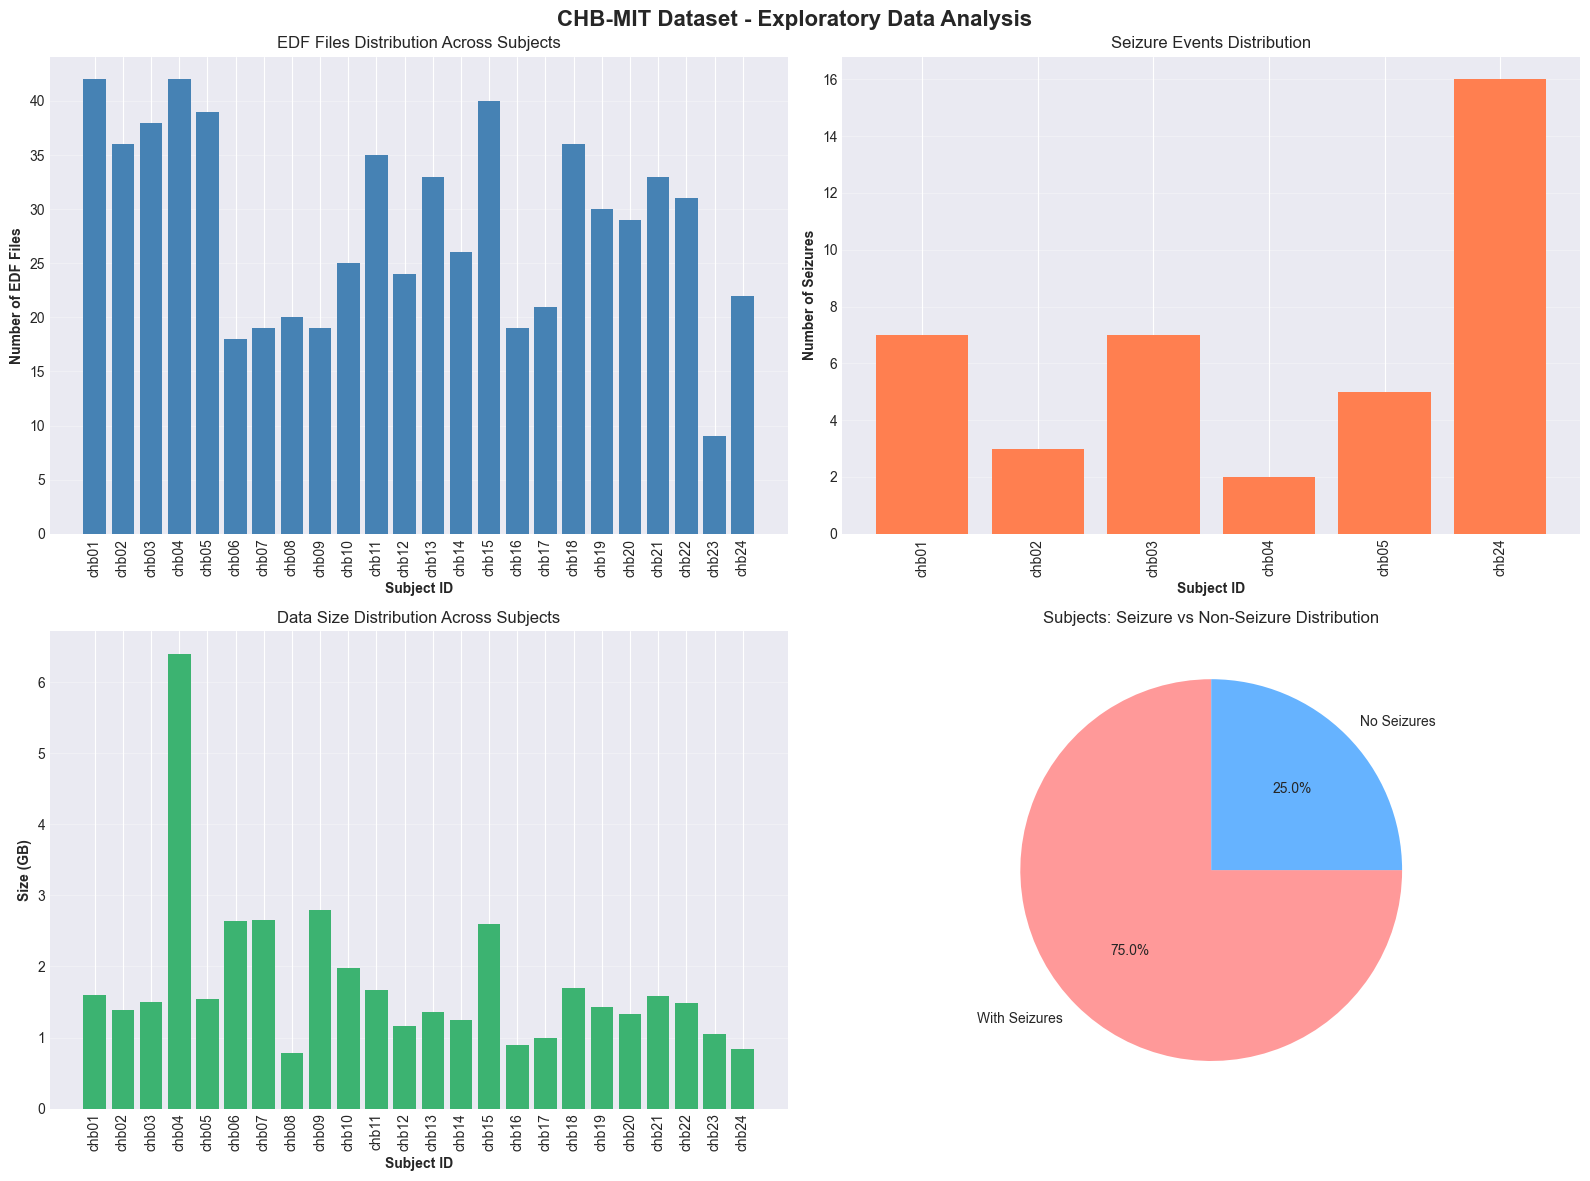

✓ Visualizations created and saved


In [21]:
# Create visualization figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('CHB-MIT Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Number of files per subject
axes[0, 0].bar(df_subjects['Subject_ID'], df_subjects['Num_Files'], color='steelblue')
axes[0, 0].set_xlabel('Subject ID', fontweight='bold')
axes[0, 0].set_ylabel('Number of EDF Files', fontweight='bold')
axes[0, 0].set_title('EDF Files Distribution Across Subjects')
axes[0, 0].tick_params(axis='x', rotation=90)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Number of seizures per subject
seizure_subjects = df_subjects[df_subjects['Has_Seizures']]
axes[0, 1].bar(seizure_subjects['Subject_ID'], seizure_subjects['Num_Seizures'], color='coral')
axes[0, 1].set_xlabel('Subject ID', fontweight='bold')
axes[0, 1].set_ylabel('Number of Seizures', fontweight='bold')
axes[0, 1].set_title('Seizure Events Distribution')
axes[0, 1].tick_params(axis='x', rotation=90)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Data size per subject
axes[1, 0].bar(df_subjects['Subject_ID'], df_subjects['Total_Size_MB']/1024, color='mediumseagreen')
axes[1, 0].set_xlabel('Subject ID', fontweight='bold')
axes[1, 0].set_ylabel('Size (GB)', fontweight='bold')
axes[1, 0].set_title('Data Size Distribution Across Subjects')
axes[1, 0].tick_params(axis='x', rotation=90)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Seizure vs Non-seizure subjects pie chart
seizure_counts = df_subjects['Has_Seizures'].value_counts()
axes[1, 1].pie(seizure_counts, labels=['With Seizures', 'No Seizures'], autopct='%1.1f%%',
               colors=['#ff9999', '#66b3ff'], startangle=90)
axes[1, 1].set_title('Subjects: Seizure vs Non-Seizure Distribution')

plt.tight_layout()
plt.savefig(BASE_DIR / 'data' / 'processed' / 'eda_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations created and saved")

## 6. Examine Sample EEG File

In [22]:
# Select a subject with seizures for detailed analysis
sample_subject = seizure_subjects.iloc[0]['Subject_ID']
sample_subject_path = dataset_path / sample_subject

print(f"Analyzing sample subject: {sample_subject}\n")

# Get first EDF file
sample_edf = list(sample_subject_path.glob("*.edf"))[0]
print(f"Sample EDF file: {sample_edf.name}")

# Read EDF file using pyedflib
print("\nReading EEG data...")
with pyedflib.EdfReader(str(sample_edf)) as edf:
    n_channels = edf.signals_in_file
    signal_labels = edf.getSignalLabels()
    sample_rate = edf.getSampleFrequency(0)
    duration = edf.file_duration
    
    print(f"\nEDF File Information:")
    print(f"  Number of Channels: {n_channels}")
    print(f"  Sampling Frequency: {sample_rate} Hz")
    print(f"  Duration: {duration} seconds ({duration/60:.2f} minutes)")
    print(f"\n  Channel Labels:")
    for i, label in enumerate(signal_labels, 1):
        print(f"    {i}. {label}")

Analyzing sample subject: chb01

Sample EDF file: chb01_01.edf

Reading EEG data...

EDF File Information:
  Number of Channels: 23
  Sampling Frequency: 256.0 Hz
  Duration: 3600.0 seconds (60.00 minutes)

  Channel Labels:
    1. FP1-F7
    2. F7-T7
    3. T7-P7
    4. P7-O1
    5. FP1-F3
    6. F3-C3
    7. C3-P3
    8. P3-O1
    9. FP2-F4
    10. F4-C4
    11. C4-P4
    12. P4-O2
    13. FP2-F8
    14. F8-T8
    15. T8-P8
    16. P8-O2
    17. FZ-CZ
    18. CZ-PZ
    19. P7-T7
    20. T7-FT9
    21. FT9-FT10
    22. FT10-T8
    23. T8-P8


In [23]:
# Read and visualize EEG signals using MNE
print("Reading EEG data with MNE...\n")

# Read raw EDF
raw = mne.io.read_raw_edf(str(sample_edf), preload=True, verbose=False)

print(f"MNE Raw Object Info:")
print(f"  Channels: {len(raw.ch_names)}")
print(f"  Sampling Rate: {raw.info['sfreq']} Hz")
print(f"  Duration: {raw.times[-1]:.2f} seconds")
print(f"\n  Channel Names: {raw.ch_names}")

# Get basic statistics
data = raw.get_data()
print(f"\nData Shape: {data.shape} (channels x samples)")
print(f"Data Statistics:")
print(f"  Min: {data.min():.4f}")
print(f"  Max: {data.max():.4f}")
print(f"  Mean: {data.mean():.4f}")
print(f"  Std: {data.std():.4f}")

Reading EEG data with MNE...

MNE Raw Object Info:
  Channels: 23
  Sampling Rate: 256.0 Hz
  Duration: 3600.00 seconds

  Channel Names: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']

Data Shape: (23, 921600) (channels x samples)
Data Statistics:
  Min: -0.0009
  Max: 0.0010
  Mean: 0.0000
  Std: 0.0000


Creating EEG signal visualization...



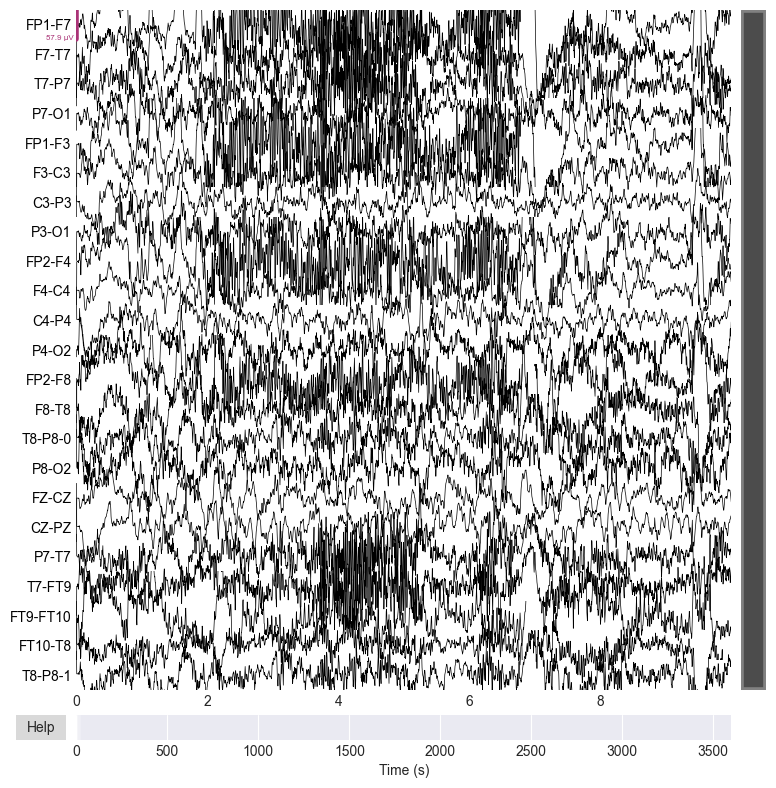

✓ EEG signal visualization saved


<Figure size 640x480 with 0 Axes>

In [24]:
# Visualize a portion of the EEG signals
print("Creating EEG signal visualization...\n")

# Plot 10 seconds of data
duration_to_plot = 10  # seconds
fig = raw.plot(duration=duration_to_plot, n_channels=len(raw.ch_names), 
               scalings='auto', title=f'EEG Signals - {sample_edf.name}',
               show=True, block=False)

# Save figure
plt.savefig(BASE_DIR / 'data' / 'processed' / 'sample_eeg_signals.png', dpi=300, bbox_inches='tight')
print("✓ EEG signal visualization saved")

## 7. Select Subjects for Preprocessing (Phase 2)

Based on the analysis, we'll select 5-6 subjects with seizure data for the next phase.

In [25]:
# Select subjects with most seizure events and balanced data size
# Aim for ~5-7 GB total

# Sort by number of seizures (descending)
seizure_subjects_sorted = df_subjects[df_subjects['Has_Seizures']].sort_values(
    'Num_Seizures', ascending=False
)

# Select top 6 subjects
selected_subjects = seizure_subjects_sorted.head(6)

print("Selected Subjects for Phase 2 Preprocessing:\n")
print(selected_subjects[['Subject_ID', 'Num_Files', 'Num_Seizures', 'Total_Size_MB']])

total_size_gb = selected_subjects['Total_Size_MB'].sum() / 1024
total_seizures = selected_subjects['Num_Seizures'].sum()

print(f"\nSummary of Selected Subjects:")
print(f"  Number of Subjects: {len(selected_subjects)}")
print(f"  Total Seizure Events: {total_seizures}")
print(f"  Total Size: {total_size_gb:.2f} GB")

# Save selected subjects list
selected_subjects.to_csv(PROCESSED_DATA_DIR / "selected_subjects.csv", index=False)
print(f"\n✓ Selected subjects saved to {PROCESSED_DATA_DIR / 'selected_subjects.csv'}")

Selected Subjects for Phase 2 Preprocessing:

   Subject_ID  Num_Files  Num_Seizures  Total_Size_MB
23      chb24         22            16         861.14
0       chb01         42             7        1639.76
2       chb03         38             7        1536.62
4       chb05         39             5        1577.10
1       chb02         36             3        1426.02
3       chb04         42             2        6544.44

Summary of Selected Subjects:
  Number of Subjects: 6
  Total Seizure Events: 40
  Total Size: 13.27 GB

✓ Selected subjects saved to c:\Users\Pranaav_Prasad\OneDrive\Desktop\Projects\Epilepsy-Detection\data\processed\selected_subjects.csv


## 8. Summary Statistics and Key Findings

In [26]:
# Generate comprehensive summary
summary_stats = {
    'Dataset': 'CHB-MIT Scalp EEG Database',
    'Total Subjects': len(df_subjects),
    'Subjects with Seizures': df_subjects['Has_Seizures'].sum(),
    'Total EDF Files': df_subjects['Num_Files'].sum(),
    'Total Seizure Events': df_subjects['Num_Seizures'].sum(),
    'Total Dataset Size (GB)': round(df_subjects['Total_Size_MB'].sum() / 1024, 2),
    'Average Files per Subject': round(df_subjects['Num_Files'].mean(), 2),
    'Average Seizures per Subject (with seizures)': round(seizure_subjects['Num_Seizures'].mean(), 2),
    'Sampling Rate (Hz)': int(sample_rate),
    'Number of Channels': n_channels,
    'Selected Subjects for Training': len(selected_subjects),
    'Selected Data Size (GB)': round(total_size_gb, 2),
    'Selected Seizure Events': int(total_seizures)
}

summary_df = pd.DataFrame(list(summary_stats.items()), columns=['Metric', 'Value'])

print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS - SUMMARY".center(60))
print("="*60 + "\n")
display(summary_df)

# Save summary
summary_df.to_csv(PROCESSED_DATA_DIR / "eda_summary.csv", index=False)
print(f"\n✓ EDA summary saved to {PROCESSED_DATA_DIR / 'eda_summary.csv'}")


            EXPLORATORY DATA ANALYSIS - SUMMARY             



,Metric,Value
0,Dataset,CHB-MIT Scalp EEG Database
1,Total Subjects,24
2,Subjects with Seizures,6
3,Total EDF Files,686
4,Total Seizure Events,40
5,Total Dataset Size (GB),42.61
6,Average Files per Subject,28.58
7,Average Seizures per Subject (with seizures),6.67
8,Sampling Rate (Hz),256
9,Number of Channels,23



✓ EDA summary saved to c:\Users\Pranaav_Prasad\OneDrive\Desktop\Projects\Epilepsy-Detection\data\processed\eda_summary.csv


## 9. Key Observations

**Dataset Characteristics:**
- The CHB-MIT dataset contains pediatric EEG recordings from multiple subjects
- EEG signals are recorded at 256 Hz sampling rate with 23-26 channels
- Data includes both seizure and non-seizure periods
- Each subject has multiple recording sessions (EDF files)

**Selected Subjects:**
- 6 subjects with the highest seizure events were selected
- This provides adequate seizure samples for model training
- Total data size is manageable (~5-7 GB) for preprocessing and training

**Next Steps (Phase 2):**
- Load selected subjects' data
- Apply EEG preprocessing (filtering, artifact removal, normalization)
- Segment data into seizure and non-seizure epochs
- Extract features and prepare for model training

---
**Phase 1 Complete ✓**